In [1]:
import tqdm
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import numpy as np
import torch

Data obtained from https://tangrams.github.io/heightmapper/ with heights between 0 and 2000 meters and a zoom level of 7.1

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Freeing alpha channels.
Garbage collected 18760 objects.
There are 10821 tiles of size 256 in the data set.
 Here is the first one:


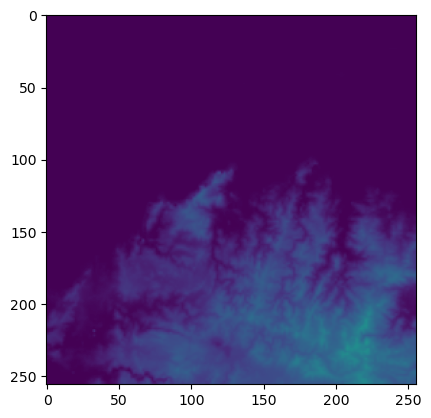

In [79]:
import os
import gc
from glob import glob
from torchvision.transforms import v2, InterpolationMode
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import rotate

class Tile:
    """
    Stores indexing info for retrieving a tile from a set of larger images.
    """
    def __init__(self, size=256, start=[0,0],
                 parent_img_key=""):
        self.size = size
        self.start = start
        self.parent_img_key = parent_img_key

    def getData(self, imgs):
        """
        Fetch the data for this tile.
        """
        img = imgs[self.parent_img_key]
        data = img[..., self.start[0]:self.start[0]+self.size, self.start[1]:self.start[1]+self.size]
        return(data)


class TiledDataset(torch.utils.data.Dataset):
    """
    A dataset for training image diffusion models.
    Takes a folder of example images, rotates them, and cuts the results up into
    interleaved axis-alligned (after the rotation) tiles.
    """
    def __init__(self, data_folder, rotations=[0,15,30,45], tile_size=256):
        """
        data_folder: Where to look for the png images.
        rotations: list of degrees by which to rotate the images for data augmentation.
        """
        self.data_folder = data_folder
        self.rotations = rotations
        self.tile_size = tile_size

        self.imgs = {} # dict of rotated images

        # find all the png images in the data folder
        data_files = glob(f"{self.data_folder}/*.png")

        with tq.tqdm(total=len(data_files)*len(self.rotations)) as pbar:
            for f in data_files:
                # update progress bar description
                pbar.set_description(f"Rotating {f}")
                
                # read the image as greyscale with alpha
                img = read_image(f, ImageReadMode.GRAY_ALPHA)
                # print(f"{type(img) = }, {img.dtype = }, {img.shape = }")
    
                # rotate the image
                for angle in self.rotations:
                    rot_img = rotate(img, angle,
                                     InterpolationMode.BILINEAR, expand=True,
                                     fill=[0,0] # black & transparent
                                    )
                    # cache the rotated version
                    key = f"{f}_{angle}"
                    self.imgs[key] = rot_img

                    # update progress bar
                    pbar.update(1)

                # break;

        # break into tiles
        self.makeTiles()

        # free some memory by dropping the alpha channel
        print(f"Freeing alpha channels.")
        for k,img in self.imgs.items():
            self.imgs[k] = img[0,:,:].contiguous() # retain only the heightmap
            pbar.update(1)
                
        # run garbage collection
        collected = gc.collect()
        print(f"Garbage collected {collected} objects.")


    def makeTiles(self):
        # break the rotated images into tiles
        self.tiles = []
        with tq.tqdm(total=len(self.imgs)) as pbar:
            for k,img in self.imgs.items():
                # update progress bar description
                pbar.set_description(f"Tiling {k}")

                # determine size of the image
                shape = img.shape[1:]

                # loop through possible tile positions:
                # starting at the edge
                for x in range(0, shape[0]-self.tile_size, self.tile_size):
                    for y in range(0, shape[1]-self.tile_size, self.tile_size):
                        # create the tile
                        tile = Tile(size=self.tile_size,
                                    start=[x,y],
                                    parent_img_key=k)

                        data = tile.getData(self.imgs)
                        hmap = data[0,...]  # first chanel is the height map
                        alpha = data[1,...] # second chanel is transparency

                        # ignore any tile with active transparency, as it has a part beyond original image
                        n_opaque_pixels = torch.count_nonzero(alpha)
                        if(n_opaque_pixels < self.tile_size*self.tile_size):
                            continue # skip to next tile

                        # skip any tiles that their have heightmap mostly filled with 0; flat water is not fun.
                        n_land_pixels = torch.count_nonzero(hmap)
                        if(n_land_pixels < 0.3 * self.tile_size*self.tile_size):
                            continue # skip to next tile

                        # this is a good tile, let's cache it
                        self.tiles.append(tile)
                
                # update progress bar
                pbar.update(1)

                # break
        
        
#     def denormalize(self, y):
#         return(y*self.std + self.mean)

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, index):
        tile_data = self.tiles[index].getData(self.imgs)
        return (tile_data)


DS = TiledDataset("../Data",
                  # rotations=[15]
                 )

print(f"There are {len(DS)} tiles of size {DS.tile_size} in the data set.\n Here is the first one:")
plt.imshow(DS[0], vmin=0, vmax=255)
plt.show()

An example rotated image with acepted tiles highlighted:

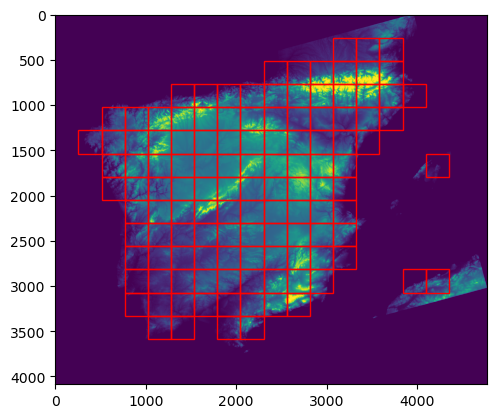

In [81]:
# # draw the heightmap and transparency
# hmap = DS.imgs['../Data/Spain.png_15'][0,:,:]
# alpha = DS.imgs['../Data/Spain.png_15'][1,:,:]
# masked = np.ma.masked_where(alpha<255, hmap)
# plt.imshow(masked, vmin=0, vmax=255)

# draw only the heightmap
hmap = DS.imgs['../Data/Spain.png_15'][:,:]
plt.imshow(hmap, vmin=0, vmax=255)

ax = plt.gca()

# draw the accepted tiles
import matplotlib.patches as patches
for tile in DS.tiles:
    if tile.parent_img_key == '../Data/Spain.png_15':
        rect = patches.Rectangle((tile.start[1],tile.start[0]),
                                 tile.size, tile.size,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.show()